Acceleromter Stuff
====
Initial exploration

### Prerequisites
The right version of python and various packages and probably a GPU

### where the data is
I've copied a single accelerometer file into the `data/` directory to do this initial exploration.

This isn't a viable long-term solution, but downloading from RDSF takes forever

I've also mounted the RDSF files on my `Z:` drive - change this in `userconf.yaml` if you've done something different

In [1]:
# I've written some modules
from ema import read, parse, analysis

### Choose a participant and check if they consented

In [2]:
device_id = "6012582"
recording_id = "0000291121"
participant_id = "20029"

if not read.consented(participant_id):
    raise ValueError(f"Participant {participant_id} didn't consent")

/home/mh19137/seaco_malaysia/ema/read.py:55: DtypeWarning: Columns (17,25,26,52,197,198,200,201,209,210,212,213,216,218,219,222,225,227,228,230,231,233,234,236,237,239,240,243,246,248,249,252,254,255,257,258,261,263,264,267,269,270,272,273,276,279,281,284,291,293,294,296,297,300,302,303,305,306,309,311,312,314,315,317,318,321,324,327,330,344,351,352,354,355,360,361,362,363,364,369,370,371,372,373,378,379,380,381,382,387,390,391,396,397,398,399,400,406,407,415,425,432,434,435,436,446,456,486,499,504,506,512,513,549) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path)


In [3]:
# Find the accelerometer file
import pathlib

filename = f"{device_id}_{recording_id}-{participant_id}.cwa"
filepath = pathlib.Path(rf"data/{filename}")

# TODO add some code to look for the right files in all the "Week X" folders

assert filepath.exists()

In [4]:
""" Find the smartwatch data from the combined smartwatch file """
meal_df = read.meal_info(participant_id)
allowed_meal_types = {"Snack", "Drink", "Meal", "No food/drink"}
meal_df = parse.extract_meals(meal_df, allowed_meal_types, verbose=True)

Discarding: {'Catch-up end': 1, 'Catch-up start': 1, 'No catch-up': 2, 'No response': 72}
Kept: {'Drink': 35, 'Meal': 37, 'No food/drink': 4, 'Snack': 2}


In [5]:
""" Read the accelerometry file """
samples = read.accel_info(str(filepath))

In [6]:
# Use time as the index
samples.set_index("time", inplace=True, verify_integrity=False)

In [7]:
""" Find the total magnitude of acceleration """
import numpy as np

samples["magnitude"] = np.sqrt(
    samples["accel_x"] ** 2 + samples["accel_y"] ** 2 + (samples["accel_z"] - 1) ** 2
)

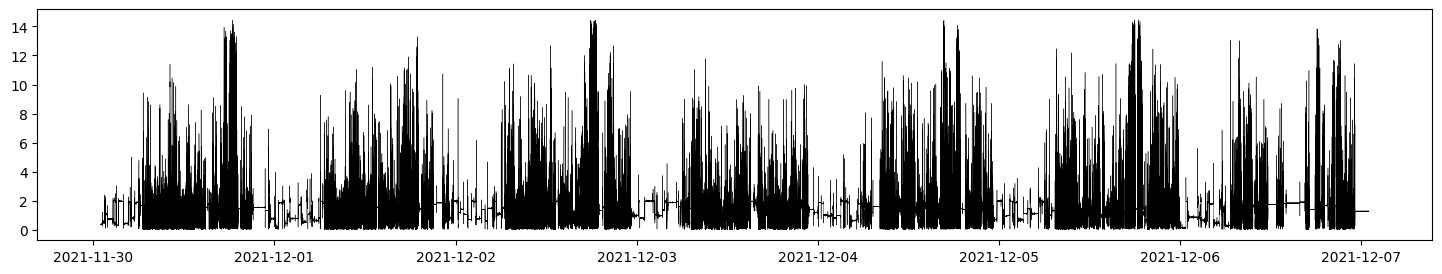

In [8]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize=(18, 3))

# Plot Accelerometry
axis.plot(samples.index, samples["magnitude"], linewidth=0.3, color="k")

In [9]:
from pandas import Timedelta, to_datetime

# Find meal times
meal_times = meal_df["date"].map(str) + meal_df["timestamp"]

# Find an hour slot before each meal
ends = to_datetime(meal_times, format=r"%d%b%Y%H:%M:%S")
starts = ends - Timedelta(1, "hour")

In [10]:
meal_df["meal_type"]

6768             Meal
6769             Meal
6770    No food/drink
6771             Meal
6772            Drink
            ...      
6909             Meal
6910            Drink
6911             Meal
6912            Drink
6913            Drink
Name: meal_type, Length: 78, dtype: object

In [11]:
# Plot the total acceleration in an hour slow before each was recorded
import pathlib
from tqdm import tqdm

# Make interactive plotting work
import PyQt6.QtCore
import os
os.environ["QT_API"] = "pyqt5"

%matplotlib qt


keep = meal_df["meal_type"] == "Meal"
n_meals = np.sum(keep)

plot_dir = pathlib.Path("plots/")

if not plot_dir.is_dir():
    plot_dir.mkdir()

# To explore some of the time series...
for i, (start, end) in tqdm(enumerate(zip(starts[keep], ends[keep]))):
    # First few are empty
    if i < 5:
        continue

    fig, axis = plt.subplots(figsize=(12, 4))
    samples.loc[start:end]["magnitude"].plot(ax=axis)

    break


5it [00:01,  3.65it/s]
